In [1]:
import torch, glob, os
import numpy as np

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
# train val data path, checkpoint config
model_type = 'mlp'
version_type = 'ver1'
convet_index_dict = {'ver1': 'Integer', 'ver2': 'EIIP', 'ver3': 'Atomic', 'ver4': 'Voss'}
if model_type == 'cnn':
    npy_path = f'./np_image_totalunit/tsne-binary-perplexity=5-pixel=100[{convet_index_dict[version_type]}]/'
    save_weight_path = f'./model/weights_res18_tsne-binary-perplexity=50-pixel=100[{convet_index_dict[version_type]}]/'
    npy_data_list = [os.path.join(npy_path,'image_npy',i ) for i in sorted(os.listdir(os.path.join(npy_path,'image_npy')))]
else:
    npy_path = f'./np_image_totalunit/mlp_{convet_index_dict[version_type]}/'
    save_weight_path =f'./model/weights_mlp-binary-[{convet_index_dict[version_type]}]/'
    npy_data_list = np.load(f'./np_image_totalunit/mlp_{convet_index_dict[version_type]}/gene.npy')

weights_name = f"weights_binaryclass_Covid19[-NACGT].final-{convet_index_dict[version_type]}.pt"
path2weights = os.path.join(save_weight_path,weights_name)
label_ = np.load(os.path.join(npy_path,'label.npy'))

# split train, val data
X_train, X_test, y_train, y_test = train_test_split(npy_data_list, label_,stratify = label_, test_size=0.25, random_state=42)
X_train, _, y_train, _ = train_test_split(X_train, y_train,stratify = y_train, test_size=0.15, random_state=42)
print('train: ', len(X_train), '|| test: ', len(X_test)) 

train:  723 || test:  284


In [3]:
from function import torch_dataset_func
from train_val import test_model
test_ld = torch_dataset_func(model_type = model_type)
test_ds = test_ld.get_TransferDataset(data_list= X_test, labels= y_test, batch_size = len(X_test), shuffle = False)
start_test = test_model()

if model_type !='cnn':
    start_test.model_config(model_type = model_type, data_shape = X_train.shape, class_num = 1, use_cuda = False)
else:
    start_test.model_config(model_type = model_type, data_shape = None, class_num = 1, use_cuda = False)
start_test.ck_loader(path2weights)

In [4]:
prob, label_ = start_test.test_process(test_ds, output='numpy')

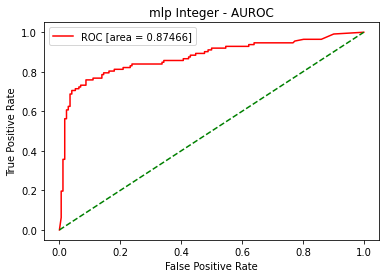

In [5]:
start_test.get_metric(save_name=os.path.join('./log_',weights_name[0:-3]+'-AUROC.jpg'), 
                                            fig_name=f'{model_type} {convet_index_dict[version_type]} - AUROC')

In [6]:
def pred_fun(X_test, model = start_test.get_model()):
    X_tensor = torch.from_numpy(X_test).float()
    model.eval()
    with torch.no_grad():
        prob = model(X_tensor.to('cpu'))
        # prob = torch.nn.functional.softmax(prob, dim=1)
    return prob.detach().cpu().numpy()

In [7]:
import pandas as pd
filter_csv_1000 = pd.read_csv('./dataset_1401/ver1 to ver3  boruta choose 1000 position summary upate  ver2 20220531.csv')
selection_filter = sorted(np.array(filter_csv_1000[version_type])) #python list index start from 0
selection_filter[0:5]

[266, 268, 269, 270, 271]

In [8]:
import matplotlib.pyplot as plt
if model_type=='mlp':
    import shap
    print(X_train.shape)
    explainer = shap.KernelExplainer(pred_fun, X_train[0:50])
    shap_values = explainer.shap_values(X_train[0:20])
    
    shap.initjs()
    if version_type=='ver4':

        voss_feature_name = []
        for i in selection_filter:
            for j in '-ACGNT':
                voss_feature_name.append(f'{i} {j}')
        selection_filter = voss_feature_name
    else:
        pass
    shap.summary_plot(shap_values,
                                                X_train[0:20].astype(np.float64),
                                                feature_names=selection_filter, 
                                                plot_size=(10,14),
                                                show=False)
    plt.title(f'{convet_index_dict[version_type]} - {model_type}')                                        
    plt.savefig(f'./log_/{model_type} - {convet_index_dict[version_type]}.jpg',format = "jpg",bbox_inches = 'tight')
else:
    import pickle as pk
    from function import grad_cam
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    class_dict = {0:'N', 1:'Y'}
    pkl = f'./deepinsight_location_npy/tsne-binary-perplexity=50-pixel=100[{convet_index_dict[version_type]}].pkl'
    it = pk.load(open(os.path.join(pkl),'rb'))
    test_ds = test_ld.get_TransferDataset(data_list= X_test, labels= y_test, batch_size = 1, shuffle = False)
    gradcam_fun = grad_cam(device = device, path2weights = path2weights, pkl_path = pkl, class_num = 1)
    sum_image = np.zeros((100,100))
    tsne_image = np.zeros((100,100))
    for idx, (img, lab) in enumerate(test_ds):
        if int(lab)==1:
            images = img
            label = lab
            temp, temp2 = gradcam_fun.loader_cam(images, label, class_dict = class_dict, ths=0.75)
            tsne_image = tsne_image + temp2
            sum_image = sum_image + temp
    if True:
        _, axes = plt.subplots(1, 3, figsize=(20, 10))

        axes[0].imshow(tsne_image, cmap='bone'); axes[0].axis('off'); axes[0].set_title(f'lineage diff = [Y]')
        axes[1].imshow(tsne_image, cmap='bone')
        axes[1].imshow(sum_image, alpha=0.7, cmap='hot'); axes[1].axis('off'); axes[1].set_title(f'MIX')
        axes[2].imshow(sum_image, cmap='hot'); axes[2].axis('on'); axes[2].set_title(f'test diff= [Y] image stack')
        plt.show()
    feature_dict = {}
    for x, first_array in enumerate(sum_image):
        for y, second_array in enumerate(first_array):
            if second_array>0.0:
                feature_dict[x,y] = second_array
                # print((x,y), round(second_array,8))
    if version_type=='ver4':
        voss_feature_name = []
        for i in selection_filter:
            for j in '-ACGNT':
                voss_feature_name.append(f'{i} {j}')
        selection_filter = voss_feature_name
    else:
        pass
    total_feature_stack = []
    for seq_index, xy in enumerate(it.coords()):
        if tuple(xy) in list(feature_dict.keys()):
            total_feature_stack.append([round(feature_dict[tuple(xy)], 2), list(xy), str(selection_filter[seq_index])])
    total_feature_stack = sorted(total_feature_stack, reverse=True)
    plot_pd = (pd.DataFrame(total_feature_stack, columns = ['value', 'position', 'index']))[['index', 'value']].sort_values('value').tail(40)
    fig, ax = plt.subplots(figsize=(5, 10))  
    ax.barh(plot_pd['index'], plot_pd['value'])
    plt.title(f'{model_type} - {convet_index_dict[version_type]}')
    plt.savefig(os.path.join('./log_', weights_name[0:-3]+f' - {model_type} - {convet_index_dict[version_type]}.jpg'))
    plt.show()

Using 723 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


(723, 1000)


  0%|          | 0/20 [00:00<?, ?it/s]

: 

: 